<a href="https://colab.research.google.com/github/sanscurtodavis/drexel_research/blob/main/04232025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
def download_data(ticker, start_date, end_date):
  """
  Function which downloads data from yfinance
  with a start date and end date specified.
  """
  data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
  data.columns = [col[0] if col[1] == '' else f"{col[0]}" for col in data.columns]
  return data

def bollinger_bands(data, window=40, stdev=2):
  """
  Function which creates a Bollinger Bands strategy.
  Enter long when the close price is above the upper band.
  Enter short when the close price is below the lower band.
  Exit long when the close price is below the upper band.
  Exit short when the close price is above the lower band.
  """

  # Define Bollinger Band parameters in df
  data['SMA'] = data['Close'].rolling(window=window).mean()
  data['Std'] = data['Close'].rolling(window=window).std()
  data['Upper Band'] = data['SMA'] + (data['Std'] * stdev)
  data['Lower Band'] = data['SMA'] - (data['Std'] * stdev)

  # Define key account metrics
  data['Strategy Balance'] = starting_cash
  data['Buy & Hold Balance'] = starting_cash
  data['Shares'] = 0
  data['Trades'] = 0
  data['Position'] = 'hold'

  in_position = 'none'
  cash = starting_cash
  shares = 0
  trades = 0

  # Iterate through data and assign long/short positions
  for i in range(0, len(data)-1):
    price = data.iloc[i, data.columns.get_loc('Close')]
    upper = data.iloc[i, data.columns.get_loc('Upper Band')]
    lower = data.iloc[i, data.columns.get_loc('Lower Band')]

    # No prior action before
    if in_position == 'none':
      # Enter long
      if price > upper:
        shares = cash / price
        cash = 0
        in_position = 'long'
        trades += 1
        data.iloc[i, data.columns.get_loc('Position')] = 'enter long'
      # Enter short
      elif price < lower:
        shares = -cash / price
        cash = 0
        in_position = 'short'
        trades += 1
        data.iloc[i, data.columns.get_loc('Position')] = 'enter short'

    # Long prior action
    elif in_position == 'long':
      # Exit long
      if price < upper:
        cash = shares * price
        shares = 0
        in_position = 'none'
        trades += 1
        data.iloc[i, data.columns.get_loc('Position')] = 'exit long'

    # Short prior action
    elif in_position == 'short':
      # Exit short
      if price > lower:
        cash = cash + (shares * price)
        shares = 0
        in_position = 'none'
        trades += 1
        data.iloc[i, data.columns.get_loc('Position')] = 'exit short'

    # Set balance, share, and trades
    data.iloc[i, data.columns.get_loc('Shares')] = shares
    data.iloc[i, data.columns.get_loc('Trades')] = trades

    # Map Position to signal
    position_map = {
        'enter long': 1,
        'exit long': 0,
        'enter short': -1,
        'exit short': 0,
    }
    data['Signal'] = data['Position'].map(position_map).fillna(method='ffill').fillna(0)

    # Calculate returns
    data['Daily Returns'] = data['Close'].pct_change()
    data['Strategy Returns'] = data['Signal'] * data['Daily Returns']

    # Cumulative balances
    data['Strategy Balance'] = (1 + data['Strategy Returns']).cumprod() * starting_cash
    data['Buy & Hold Balance'] = (1 + data['Daily Returns']).cumprod() * starting_cash

    # Daily Gain
    data['Daily Buy and Hold Returns'] = data['Daily Returns'] * data['Buy & Hold Balance']
    data['Daily Strategy Returns'] = data['Strategy Returns'] * data['Strategy Balance']

  return data

def plot_bollinger_bands(data):
  """
  Function which plots the Bollinger Bands strategy.
  """
  plt.figure(figsize=(14, 8))

  plt.plot(data['Close'], label='Close Price', color='blue')
  plt.plot(data['Upper Band'], label='Upper Band', color='g', linestyle='--')
  plt.plot(data['Lower Band'], label='Lower Band', color='r', linestyle='--')

  long_entries = data[data['Position'] == 'enter long']
  long_exits = data[data['Position'] == 'exit long']
  short_entries = data[data['Position'] == 'enter short']
  short_exits = data[data['Position'] == 'exit short']

  plt.scatter(long_entries.index, long_entries['Close'], label='Long Entry', color='green', marker='^', alpha=1, s=100)
  plt.scatter(long_exits.index, long_exits['Close'], label='Long Exit', color='green', marker='v', alpha=1, s=100)
  plt.scatter(short_entries.index, short_entries['Close'], label='Short Entry', color='red', marker='^', alpha=1, s=100)
  plt.scatter(short_exits.index, short_exits['Close'], label='Short Exit', color='red', marker='v', alpha=1, s=100)

  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.title('Bollinger Bands Strategy for SPY')
  plt.legend()
  plt.grid()

  plt.show()

def plot_strategy_vs_benchmark(data, risk_free_rate=0.0):
  # Metrics calculation
  strategy_returns = data['Strategy Returns'].dropna()
  buy_hold_returns = data['Daily Returns'].dropna()

  daily_strategy_pnl = data['Daily Strategy Returns'].sum() / starting_cash
  daily_buy_hold_pnl = data['Daily Buy and Hold Returns'].sum() / starting_cash

  def metrics(returns, balance, pnl):
      volatility = np.std(returns) * np.sqrt(252)
      total_return = pnl
      downside = returns[returns < 0]
      sortino = (returns.mean() - risk_free_rate) / (np.std(downside) * np.sqrt(252)) if not downside.empty else np.nan
      sharpe = (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252)
      return volatility, total_return, sortino, sharpe

  vol_s, ret_s, sortino_s, sharpe_s = metrics(strategy_returns, data['Strategy Balance'], daily_strategy_pnl)
  vol_bh, ret_bh, sortino_bh, sharpe_bh = metrics(buy_hold_returns, data['Buy & Hold Balance'], daily_buy_hold_pnl)

  # Plotting
  fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [3, 2]})

  # Plot Returns
  axs[0].plot(data.index, data['Strategy Balance'], label='Strategy', color='purple')
  axs[0].plot(data.index, data['Buy & Hold Balance'], label='Buy & Hold', color='black', linestyle='--')
  axs[0].set_title('Cumulative Returns')
  axs[0].set_xlabel('Date')
  axs[0].set_ylabel('Balance')
  axs[0].legend()
  axs[0].grid()

  # Plot Metrics
  metrics_labels = ['Volatility', 'Total Return', 'Sortino Ratio', 'Sharpe Ratio']
  strategy_metrics = [vol_s, ret_s, sortino_s, sharpe_s]
  buy_hold_metrics = [vol_bh, ret_bh, sortino_bh, sharpe_bh]

  x = np.arange(len(metrics_labels))
  width = 0.35

  bars1 = axs[1].bar(x - width/2, strategy_metrics, width, label='Strategy', color='purple')
  bars2 = axs[1].bar(x + width/2, buy_hold_metrics, width, label='Buy & Hold', color='black')

  axs[1].set_ylabel('Metric Value')
  axs[1].set_title('Performance Metrics')
  axs[1].set_xticks(x)
  axs[1].set_xticklabels(metrics_labels)
  axs[1].legend()
  axs[1].grid(axis='y')

  # Annotate metrics
  for bar in bars1 + bars2:
      yval = bar.get_height()
      axs[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

  plt.tight_layout()
  plt.show()

In [3]:
starting_cash = 10000
data = download_data('GLD', '2018-01-01', '2025-01-01')
data = bollinger_bands(data)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-2-d164faf779c9>:91: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Signal'] = data['Position'].map(position_map).fillna(method='ffill').fillna(0)
<ipython-input-2-d164faf779c9>:91: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Signal'] = data['Position'].map(position_map).fillna(method='ffill').fillna(0)
<ipython-input-2-d164faf779c9>:91: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Signal'] = data['Position'].map(position_map).fillna(method='ffill').fillna(0)
<ipython-input-2-d164faf779c9>:91: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead

In [4]:
res = data[data['Position'] != 'hold']
observe = data[['Close', 'Upper Band', 'Lower Band', 'Strategy Balance', 'Buy & Hold Balance', 'Daily Returns', 'Strategy Returns', 'Position']]
observe

,Close,Upper Band,Lower Band,Strategy Balance,Buy & Hold Balance,Daily Returns,Strategy Returns,Position
Date,,,,,,,,
2018-01-02,125.150002,NaN,NaN,NaN,NaN,NaN,NaN,hold
2018-01-03,124.820000,NaN,NaN,10000.000000,9973.631496,-0.002637,-0.0,hold
2018-01-04,125.459999,NaN,NaN,10000.000000,10024.770080,0.005127,0.0,hold
2018-01-05,125.330002,NaN,NaN,10000.000000,10014.382765,-0.001036,-0.0,hold
2018-01-08,125.309998,NaN,NaN,10000.000000,10012.784341,-0.000160,-0.0,hold
...,...,...,...,...,...,...,...,...
2024-12-24,241.440002,255.428110,235.022389,56425.481257,19292.049500,0.001992,0.0,hold
2024-12-26,243.070007,254.493141,235.306358,56425.481257,19422.293597,0.006751,0.0,hold
2024-12-27,241.399994,253.234585,235.759914,56425.481257,19288.852653,-0.006871,-0.0,hold


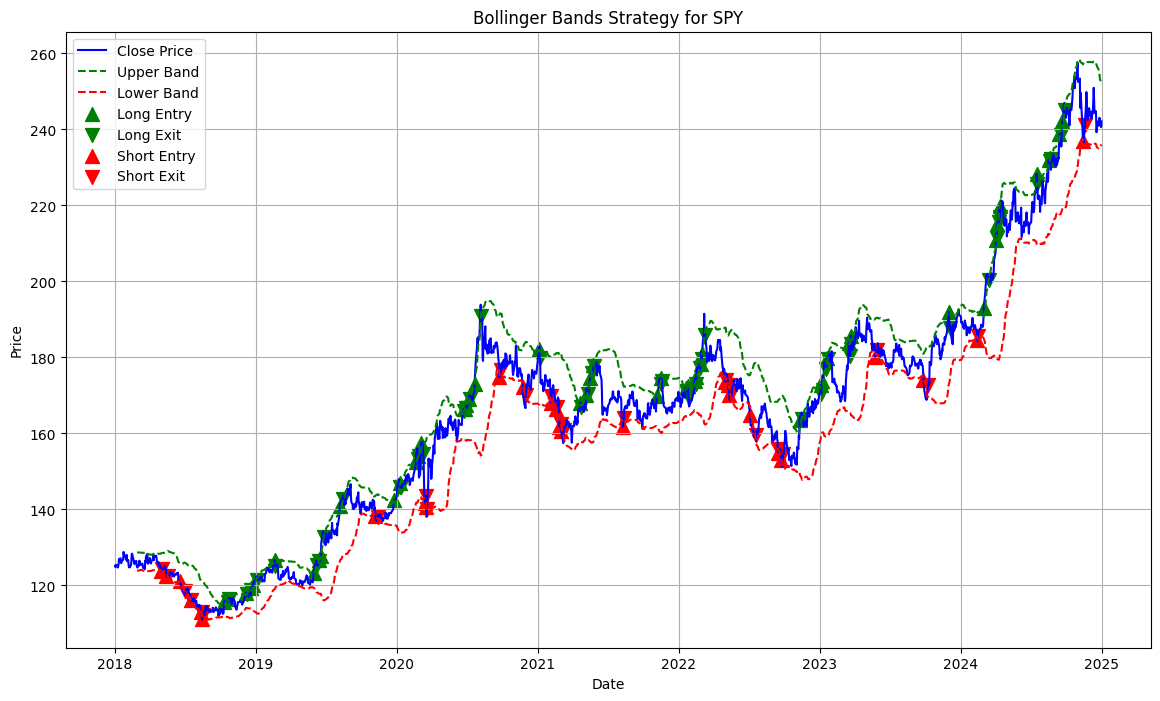

In [5]:
plot_bollinger_bands(data)

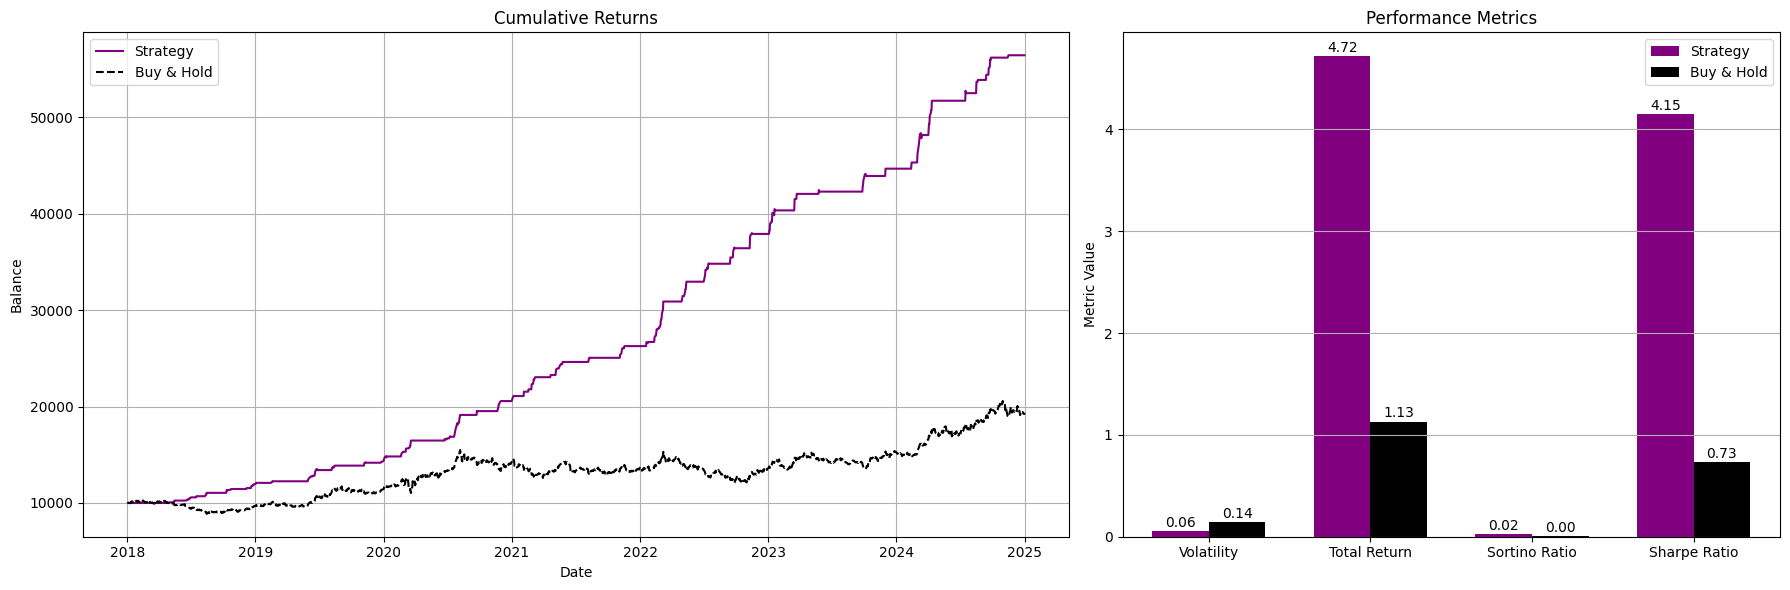

In [6]:
plot_strategy_vs_benchmark(data)